In [15]:
#conda install pydot graphviz

from __future__ import print_function
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras.utils import plot_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.models import load_model
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/News-utf-8.csv', encoding="utf-8")
df['category_id'] = df.category.factorize()[0]

def preprocess_text(sen):
    # Lowercase
    sentence = sen.lower()
    
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Zäöüß]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

df.text = df.text.apply(preprocess_text)
df[::5000]                

,category,text,category_id
0,politik,der verrohte kontinent griechische grenzschütz...,0
5000,politik,warnung ohne namen warning eine warnung so hei...,0
10000,panorama,alle bundesländer führen maskenpflicht ein die...,1
15000,panorama,frauchen verliert trennungsstreit um gemeinsam...,1
20000,sport,manchester city legt berufung gegen europapoka...,2
25000,sport,eine karriere wie ein slalomrennen felix neure...,2
30000,wirtschaft,spd will vorstandsgehälter deckeln mit einem r...,3
35000,wirtschaft,tüv süd warnt vor weiteren dammbrüchen nach de...,3
40000,technologie,facebook blendet likes aus der wettkampf um li...,4
45000,technologie,wenn der delfin das ipad mopst im sommerloch i...,4


In [3]:
# set parameters:
max_features = 20000
maxlen = 400
batch_size = 32
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 5

In [4]:
X = df['text'].values
y = df['category_id']
y = to_categorical(y, num_classes=10)
y.shape

(78321, 10)

In [5]:
print('Loading data...')
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test  = tokenizer.texts_to_sequences(x_test)

x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test  =  pad_sequences(x_test, padding='post', maxlen=maxlen)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
print('Pad sequences (samples x time)')

x_train = pad_sequences(x_train, maxlen=maxlen)
x_test  =  pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
62656 train sequences
15665 test sequences
Pad sequences (samples x time)
x_train shape: (62656, 400)
x_test shape: (15665, 400)


In [23]:
import json
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=True))

In [7]:
print('Build model...')
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))
model.add(Dropout(0.2))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(10))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Build model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 50)           1000000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 400, 50)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 398, 250)          37750     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 250)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               62750     
_________________________________________________________________
dropout_2 (Dropout)          (None, 250)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 250

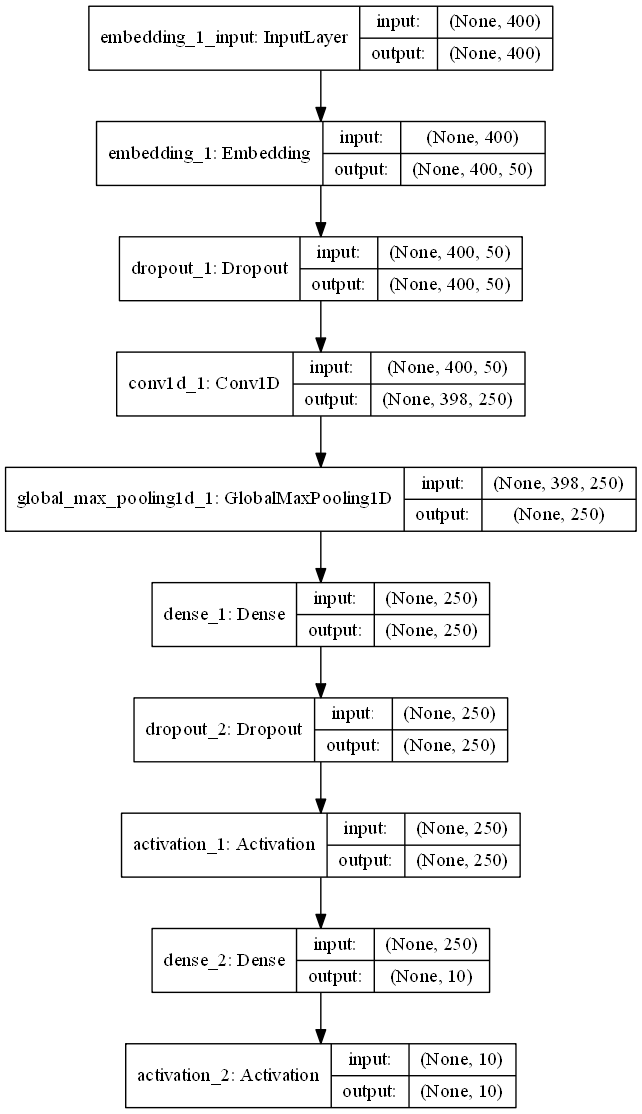

In [8]:
plot_model(model, to_file='data/CNN-model_plot.png', show_shapes=True, show_layer_names=True, dpi=100)

In [9]:
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          callbacks=[EarlyStopping(patience=3, monitor='val_loss',min_delta=0.0001)])

Train on 62656 samples, validate on 15665 samples
Epoch 1/5
62656/62656 [==============================] - 86s 1ms/step - loss: 0.1744 - accuracy: 0.9376 - val_loss: 0.1126 - val_accuracy: 0.9584
Epoch 2/5
62656/62656 [==============================] - 85s 1ms/step - loss: 0.0934 - accuracy: 0.9656 - val_loss: 0.1015 - val_accuracy: 0.9619
Epoch 3/5
62656/62656 [==============================] - 85s 1ms/step - loss: 0.0676 - accuracy: 0.9756 - val_loss: 0.1048 - val_accuracy: 0.9626
Epoch 4/5
62656/62656 [==============================] - 85s 1ms/step - loss: 0.0488 - accuracy: 0.9827 - val_loss: 0.1159 - val_accuracy: 0.9619
Epoch 5/5
62656/62656 [==============================] - 85s 1ms/step - loss: 0.0350 - accuracy: 0.9877 - val_loss: 0.1280 - val_accuracy: 0.9611


In [10]:
loss, Accuracy = model.evaluate(x_test, y_test)

print("Test Loss:", loss)
print("Test Accuracy:", Accuracy)

15665/15665 [==============================] - 5s 299us/step
Test Loss: 0.12804400299637417
Test Accuracy: 0.9611300230026245


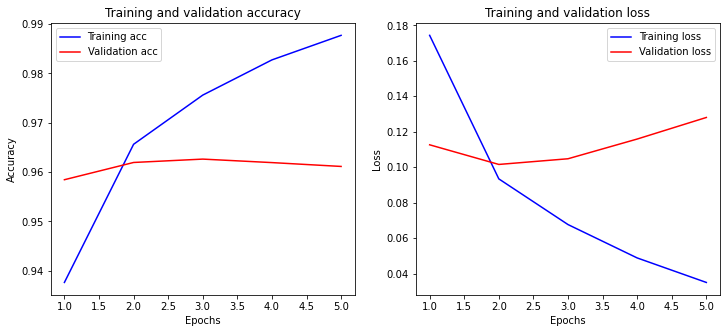

In [11]:
import matplotlib.pyplot as plt
#plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
plot_history(history)

In [19]:
model.save('CNN.h5')
model.save_weights('CNN_weights.h5')

In [13]:
import json
from keras_preprocessing.text import tokenizer_from_json

def load():
    model = load_model('app/model/CNN.h5')
    maxlen = 400
    id_to_category = {0:'politik', 1:'panorama', 2:'sport', 3:'wirtschaft',
                  4:'technologie', 5:'wissenschaft', 6:'kultur', 7:'etat', 8:'inland', 9:'international'}

    with open('app/model/tokenizer.json') as f:
        data = json.load(f)
        tokenizer = tokenizer_from_json(data)
load()

In [37]:
# Here's how to generate a prediction on individual examples
#text_labels = encoder.classes_ 
id_to_category = {0:'politik', 1:'panorama', 2:'sport', 3:'wirtschaft',
                  4:'technologie', 5:'wissenschaft', 6:'kultur', 7:'etat', 8:'inland', 9:'international'}

my_input =["atom"]

input_sequences = tokenizer.texts_to_sequences(my_input)
input_pad = pad_sequences(input_sequences, padding='post', maxlen=maxlen)

preds = model.predict(input_pad)[0]

pred_classes = np.argsort(preds)[-10:][::-1]

classes = [id_to_category[i] for i in pred_classes]
props   = preds[pred_classes]

result={}
for c, p in zip(classes, props):
    #result.append("{} {:.2f} %".format(c,p*100))
    result[c] = round(p*100,2)
result

{'wissenschaft': 40.88,
 'kultur': 29.84,
 'panorama': 21.24,
 'sport': 17.83,
 'politik': 15.09,
 'wirtschaft': 13.61,
 'technologie': 10.09,
 'inland': 0.43,
 'etat': 0.16,
 'international': 0.06}

UnpicklingError: invalid load key, 'H'.